In [1]:
import numpy as np
from tqdm import tqdm
import gymnasium as gym
from gymnasium.wrappers import FlattenObservation, RecordEpisodeStatistics

from clinic_environment import ClinicEnv
from clinic_agent import ClinicAgent

In [2]:
learning_rate = 0.01
n_episodes = 500_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

In [3]:
clinic_capacity = np.array([1, 2])
clinic_travel_times = np.array([[0, 10], [10, 0]])
patient_times = np.array([30, 40])
num_nurses = 2

unwrapped_clinic_env = ClinicEnv(clinic_capacity, clinic_travel_times, patient_times, num_nurses)
clinic_env = RecordEpisodeStatistics(FlattenObservation(unwrapped_clinic_env))
clinic_env.get_valid_actions = unwrapped_clinic_env.get_valid_actions

In [4]:
agent = ClinicAgent(
    clinic_env, 
    learning_rate=learning_rate, 
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [5]:
for episode in tqdm(range(n_episodes)):
    obs, info = clinic_env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = clinic_env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|███████████████████████████████████████████████████████| 500000/500000 [12:19<00:00, 676.18it/s]


In [6]:
obs, info = clinic_env.reset()
done = False

while not done:
    print(obs)
    action = agent.get_action(obs, randomize=False)
    print(action)
    next_obs, reward, terminated, truncated, info = clinic_env.step(action)
    
    done = terminated or truncated
    obs = next_obs
    
print(obs)

[ 0.  1.  0.  2.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.
  0.  1.  0.  0. 30.  0.  1.  0.  0.  1.  0.  0. 40.]
2
[ 0.  1.  1.  2.  0.  0.  1.  1.  0. 15.  0.  1.  0.  0.  0.  0.  1.  0.
  0.  1.  0.  0. 30.  0.  0.  1.  0.  0.  1.  0. 40.]
4
[ 0.  1.  1.  2.  0.  1.  0.  1.  0. 10.  0.  0.  1.  0.  5.  0.  1.  0.
  0.  1.  0.  0. 30.  5.  0.  1.  0.  0.  1.  0. 40.]
0
[ 0.  1.  1.  2.  0.  0.  1.  1.  0. 10.  0.  0.  1.  0.  5.  0.  1.  0.
  0.  1.  0.  0. 30.  5.  0.  1.  0.  0.  1.  0. 40.]
0
[ 0.  1.  1.  2.  0.  1.  0.  1.  0.  5.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  1.  0.  0. 30. 10.  0.  1.  0.  0.  1.  0. 40.]
0
[ 0.  1.  1.  2.  0.  0.  1.  1.  0.  5.  0.  0.  1.  0.  0.  0.  1.  0.
  0.  1.  0.  0. 30. 10.  0.  1.  0.  0.  1.  0. 40.]
1
[ 0.  1.  1.  2.  1.  1.  0.  1.  0.  0.  0.  0.  1. 10.  0.  5.  0.  1.
  0.  0.  0.  1. 30. 15.  0.  1.  0.  0.  1.  0. 40.]
0
[ 0.  1.  1.  2.  1.  0.  1.  1.  0.  0.  0.  0.  1. 10.  0.  5.  0.  1.
  0.  0.  0.  1. 30. 15.

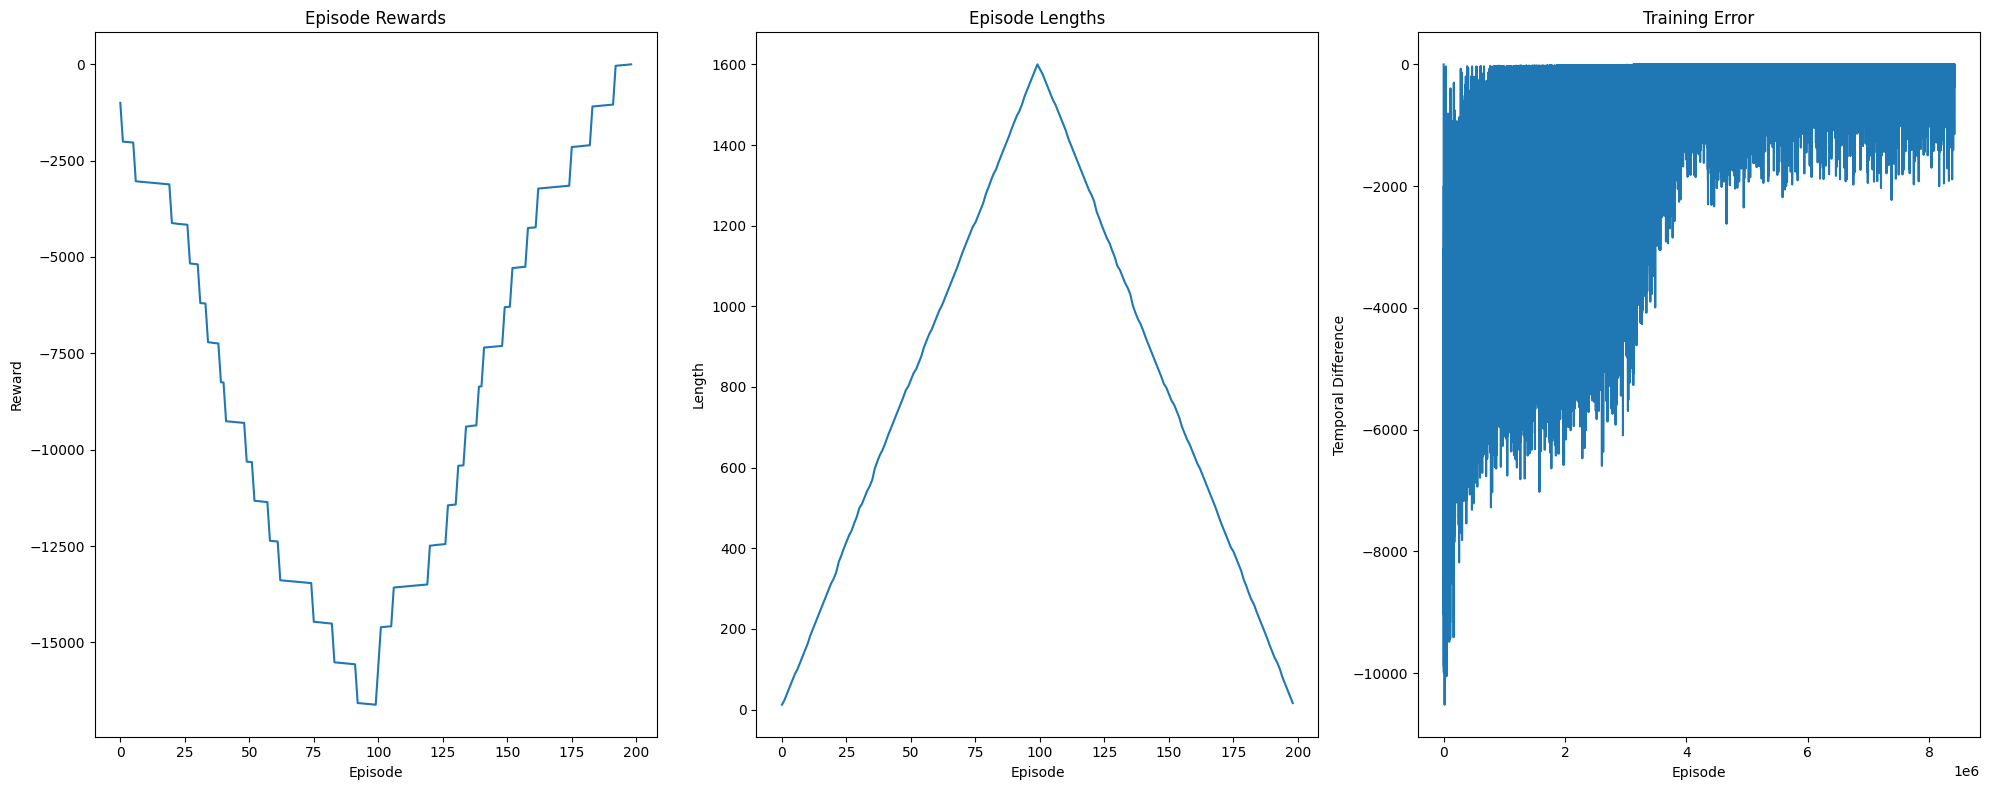

In [7]:
from matplotlib import pyplot as plt
# visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# np.convolve will compute the rolling mean for 100 episodes

axs[0].plot(np.convolve(clinic_env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(clinic_env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()